In [13]:
import os
import cv2
import glob
import pickle
import numpy as np
from tqdm import tqdm
from keras.utils import normalize
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from matplotlib.patches import Rectangle
from sklearn.metrics import average_precision_score

SIZE_X = 128
SIZE_Y = 128
n_channels = 3
n_classes = 10
Batch_size = 8
EPOCHS = 100
MODEL = 'unet'
BACKBONE = 'mobilenetv2'
encoder_weights = 'imagenet'
activation = 'softmax'
parent_directory = r'E:\Segmentation\datasets\FloodNet-Supervised_v1.0'

In [14]:
def load_images(parent_directory, split='train'):
    images = []
    masks = [] 

    image_folder_path = f'{parent_directory}\{split}\{split}-org-img'
    for img_path in tqdm(glob.glob(os.path.join(image_folder_path, "*.jpg"))):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        images.append(img)

        mask_path = (img_path.replace('org', 'label')).replace('jpg', 'png')
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        masks.append(mask)
                
    images = np.array(images)
    masks = np.array(masks)

    print(f'{split.upper()}: Images loaded: {images.shape[0]}')
    print(f'{split.upper()}: Masks loaded: {masks.shape[0]}')

    return images, masks

In [15]:
def preprocess_data(images, masks, unet_preporcessing):
    if unet_preporcessing:
        images = unet_preporcessing(images)
    else:
        images = normalize(images, axis=1)
        
    masks = np.expand_dims(masks, axis=-1)
    masks = to_categorical(masks, num_classes=n_classes)
    masks = masks.reshape((masks.shape[0], masks.shape[1], masks.shape[2], n_classes))

    return images, masks

In [16]:
def display_images_with_masks(image, mask, predicted):
    
    class_map= {'Background':0, 'Building-flooded':1, 'Building-non-flooded':2, 'Road-flooded':3, 'Road-non-flooded':4, 'Water':5, 'Tree':6, 'Vehicle':7, 'Pool':8, 'Grass':9}

    color_map = {
        "Background": [0, 0, 0],
        "Building-flooded": [255, 0, 0],
        "Building-non-flooded": [0, 255, 0],
        "Road-flooded": [0, 255, 120],
        "Road-non-flooded": [0, 0, 255],
        "Water": [255, 0, 255],
        "Tree": [70, 70, 70],
        "Vehicle": [102, 102, 156],
        "Pool": [190, 153, 153],
        "Grass": [180, 165, 180]
    }

    handles = [
        Rectangle((0, 0), 1, 1, color=np.array(c)/255) for n, c in color_map.items()
    ]
    labels = [n for n, c in color_map.items()]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    plt.title('Image')

    plt.subplot(1, 3, 2)
    mask_colored = np.zeros_like(image, dtype=np.uint8)
    for class_name, class_idx in class_map.items():
        color = color_map[class_name]
        mask_indices = np.where(mask == class_idx)
        mask_colored[mask_indices[0], mask_indices[1], :] = color
    plt.imshow(cv2.cvtColor(mask_colored, cv2.COLOR_BGR2RGB))
    plt.title('Ground-Truth Mask')

    plt.subplot(1, 3, 3)
    mask_colored1 = np.zeros_like(image, dtype=np.uint8)
    for class_name1, class_idx1 in class_map.items():
        color1 = color_map[class_name1]
        mask_indices1 = np.where(predicted == class_idx1)
        mask_colored1[mask_indices1[0], mask_indices1[1], :] = color1
    plt.imshow(cv2.cvtColor(mask_colored1, cv2.COLOR_BGR2RGB))
    plt.title('Predicted Mask')

    plt.legend(handles, labels, bbox_to_anchor =(-0.8,-0.5), loc='lower center', ncol=5)
    plt.show()

In [ ]:
#Load the images
train_images, train_masks = load_images(parent_directory, split='train')
val_images, val_masks = load_images(parent_directory, split='val')

In [ ]:
data_to_save = {
    'train_images': train_images,
    'train_masks': train_masks,
    'val_images': val_images,
    'val_masks': val_masks
}

pickle_file_path = 'dataset/train_and_val_data.pickle'

with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(data_to_save, pickle_file)

print(f'Data saved to {pickle_file_path}')

print('Shapes of loaded data:')
print('Train Images:', train_images.shape)
print('Train Masks:', train_masks.shape)
print('Val Images:', val_images.shape)
print('Val Masks:', val_masks.shape)

In [17]:
pickle_file_path = '../dataset/train_and_val_data.pickle'

with open(pickle_file_path, 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

train_images = loaded_data['train_images']
train_masks = loaded_data['train_masks']
val_images = loaded_data['val_images']
val_masks = loaded_data['val_masks']

print('Shapes of loaded data:')
print('Train Images:', train_images.shape)
print('Train Masks:', train_masks.shape)
print('Val Images:', val_images.shape)
print('Val Masks:', val_masks.shape)

Shapes of loaded data:
Train Images: (1445, 128, 128, 3)
Train Masks: (1445, 128, 128)
Val Images: (450, 128, 128, 3)
Val Masks: (450, 128, 128)


In [18]:
import segmentation_models as sm

preprocess_input = sm.get_preprocessing(BACKBONE)

train_images, train_masks = preprocess_data(train_images, train_masks, preprocess_input)
val_images, val_masks = preprocess_data(val_images, val_masks, preprocess_input)

print('Shapes of loaded data:')
print('Train Images:', train_images.shape)
print('Train Masks:', train_masks.shape)
print('Val Images:', val_images.shape)
print('Val Masks:', val_masks.shape)

Shapes of loaded data:
Train Images: (1445, 128, 128, 3)
Train Masks: (1445, 128, 128, 10)
Val Images: (450, 128, 128, 3)
Val Masks: (450, 128, 128, 10)


In [19]:
if MODEL == 'unet':
    model = sm.Unet(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
elif MODEL == 'fpn':
    model = sm.FPN(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
elif MODEL == 'pspnet':
    model = sm.PSPNet(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
elif MODEL == 'linknet':
    model = sm.Linknet(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
else:
    raise ValueError('Unknown model')

model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1_pad (ZeroPadding2D)      (None, 129, 129, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['Conv1_pad[0][0]']              
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']            

In [20]:
history = model.fit(x=train_images, y=train_masks, batch_size=Batch_size, epochs=EPOCHS, validation_data=(val_images, val_masks))

Epoch 1/100
181/181 [==============================] - 20s 71ms/step - loss: 0.9844 - iou_score: 0.2127 - val_loss: 2.0409 - val_iou_score: 0.0361
Epoch 2/100
181/181 [==============================] - 10s 55ms/step - loss: 0.8081 - iou_score: 0.3107 - val_loss: 1.1481 - val_iou_score: 0.1275
Epoch 3/100
181/181 [==============================] - 10s 55ms/step - loss: 0.7596 - iou_score: 0.3508 - val_loss: 0.9900 - val_iou_score: 0.1914
Epoch 4/100
181/181 [==============================] - 11s 59ms/step - loss: 0.7293 - iou_score: 0.3744 - val_loss: 0.9313 - val_iou_score: 0.2236
Epoch 5/100
181/181 [==============================] - 11s 59ms/step - loss: 0.7196 - iou_score: 0.3823 - val_loss: 0.9108 - val_iou_score: 0.2328
Epoch 6/100
181/181 [==============================] - 10s 55ms/step - loss: 0.6908 - iou_score: 0.4077 - val_loss: 0.8826 - val_iou_score: 0.2557
Epoch 7/100
181/181 [==============================] - 10s 55ms/step - loss: 0.6535 - iou_score: 0.4410 - val_loss: 0.

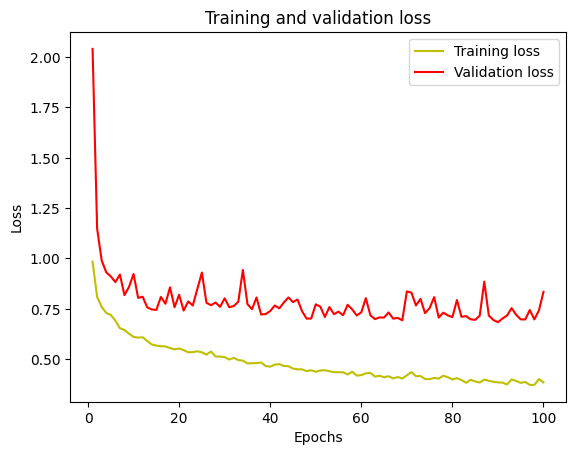

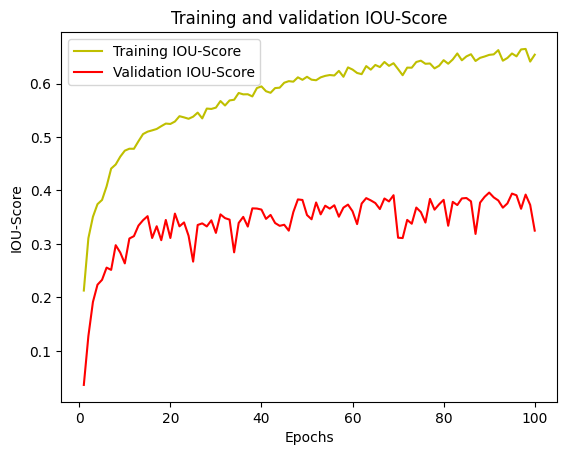

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU-Score')
plt.plot(epochs, val_acc, 'r', label='Validation IOU-Score')
plt.title('Training and validation IOU-Score')
plt.xlabel('Epochs')
plt.ylabel('IOU-Score')
plt.legend()
plt.show()

In [22]:
model.save(f'weights/{MODEL.upper()}_model_with_{EPOCHS}_epochs({MODEL.upper()}_{BACKBONE.capitalize()}).hdf5')

In [81]:
model.load_weights(f'weights/{MODEL.upper()}_model_with_{EPOCHS}_epochs({MODEL.upper()}_{BACKBONE.capitalize()}).hdf5')

In [23]:
test_images, test_masks = load_images(parent_directory, split='test')
test_images_seperate = test_images

test_images, test_masks = preprocess_data(test_images, test_masks, preprocess_input)

100%|██████████| 448/448 [02:24<00:00,  3.09it/s]

TEST: Images loaded: 448
TEST: Masks loaded: 448


In [24]:
data_to_save = {
    'test_images': test_images,
    'test_masks': test_masks,
    'test_images_seperate': test_images_seperate
}

pickle_file_path = '../dataset/test_data.pickle'

with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(data_to_save, pickle_file)

print(f'Data saved to {pickle_file_path}')

print('Shapes of loaded data:')
print('Test Images:', test_images.shape)
print('Test Masks:', test_masks.shape)

Data saved to ../dataset/test_data.pickle
Shapes of loaded data:
Test Images: (448, 128, 128, 3)
Test Masks: (448, 128, 128, 10)


In [23]:
pickle_file_path = '../dataset/test_data.pickle'

with open(pickle_file_path, 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

test_images = loaded_data['test_images']
test_masks = loaded_data['test_masks']
test_images_seperate = loaded_data['test_images_seperate']

test_images, test_masks = preprocess_data(test_images, test_masks, preprocess_input)

print('Shapes of loaded data:')
print('Test Images:', test_images.shape)
print('Test Masks:', test_masks.shape)

Shapes of loaded data:
Test Images: (448, 128, 128, 3)
Test Masks: (448, 128, 128, 10)


In [24]:
_, acc = model.evaluate(test_images, test_masks, verbose=0)
print("Accuracy is = ", (acc * 100.0), "%")

Accuracy is =  37.99976408481598 %


In [25]:
from keras.metrics import MeanIoU
import numpy as np

y_pred = model.predict(test_images)
predicted_masks = np.argmax(y_pred, axis=-1)
test_masks_ = np.argmax(test_masks, axis=-1)

print(predicted_masks.shape)
print(test_masks_.shape)

14/14 [==============================] - 2s 37ms/step
(448, 128, 128)
(448, 128, 128)


In [26]:
class_names = ["Background", "Building Flooded", "Building Non-Flooded", "Road Flooded", "Road Non-Flooded",
               "Water", "Tree", "Vehicle", "Pool", "Grass"]

n_classes = len(class_names)  
IOU_keras = MeanIoU(num_classes=n_classes)

IOU_keras.update_state(test_masks_, predicted_masks)
print("Mean IoU =", IOU_keras.result().numpy())

values = np.array(IOU_keras.get_weights())
values = values.reshape(n_classes, n_classes)

class_IoUs = []
print("IoU for each class:")
for i in range(n_classes):
    class_IoU = values[i, i] / (np.sum(values[i, :]) + np.sum(values[:, i]) - values[i, i])
    class_IoUs.append(class_IoU)
    print(f"{class_names[i]}: {class_IoU}")

class_APs = []

for i in range(n_classes):
    class_predicted_masks = (predicted_masks == i).astype(int)
    class_test_masks = (test_masks_ == i).astype(int)
    
    class_predicted_masks_flat = class_predicted_masks.flatten().reshape(-1, 1)
    class_test_masks_flat = class_test_masks.flatten().reshape(-1, 1)
    
    class_APs.append(average_precision_score(class_test_masks_flat, class_predicted_masks_flat, average='micro'))

mAP_score = np.mean(class_APs)
print("Overall mAP score =", mAP_score)

Mean IoU = 0.5040684
IoU for each class:
Background: 0.15853345394134521
Building Flooded: 0.6171708703041077
Building Non-Flooded: 0.6791965365409851
Road Flooded: 0.3722028136253357
Road Non-Flooded: 0.7246546149253845
Water: 0.2269546538591385
Tree: 0.739032506942749
Vehicle: 0.29660430550575256
Pool: 0.4173356294631958
Grass: 0.8089985251426697
Overall mAP score = 0.4901791515515629


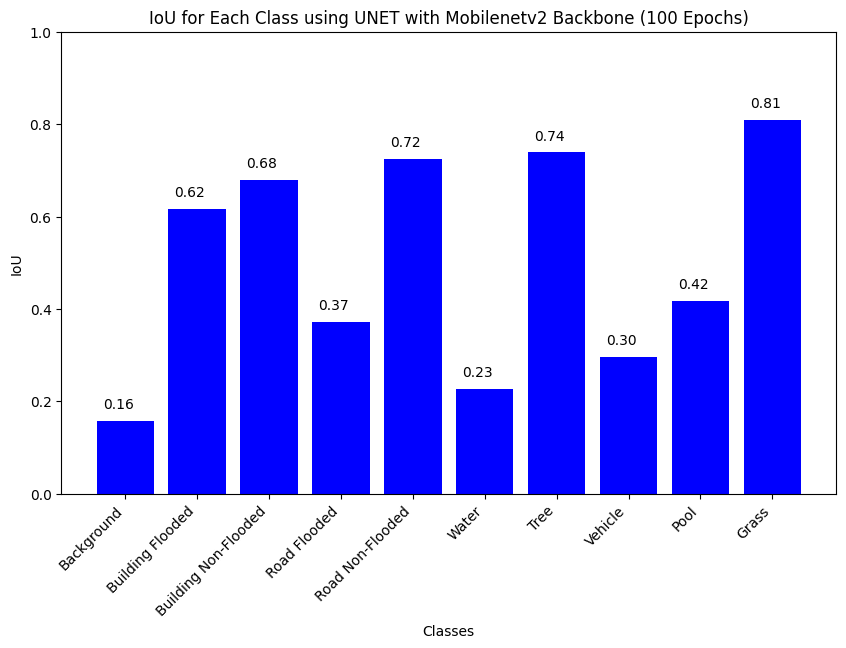

In [27]:
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, class_IoUs, color='blue')
plt.title(f'IoU for Each Class using {MODEL.upper()} with {BACKBONE.capitalize()} Backbone ({EPOCHS} Epochs)')
plt.xlabel('Classes')
plt.ylabel('IoU')
plt.ylim(0, 1) 
plt.xticks(rotation=45, ha='right')  

for bar, value in zip(bars, class_IoUs):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.02, f'{value:.2f}', ha='center', va='bottom')

plt.show()

In [28]:
def display_random_function():
    image_id = np.random.randint(0, len(test_images))
    image = test_images_seperate[image_id]
    ground_truth_mask = test_masks_[image_id]
    predicted_mask = predicted_masks[image_id]

    print(f'Image Shape: {image.shape}')
    print(f'Ground Truth Mask Shape: {ground_truth_mask.shape}')
    print(f'Predicted Mask Shape: {predicted_mask.shape}')

    display_images_with_masks(image, ground_truth_mask, predicted_mask)

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


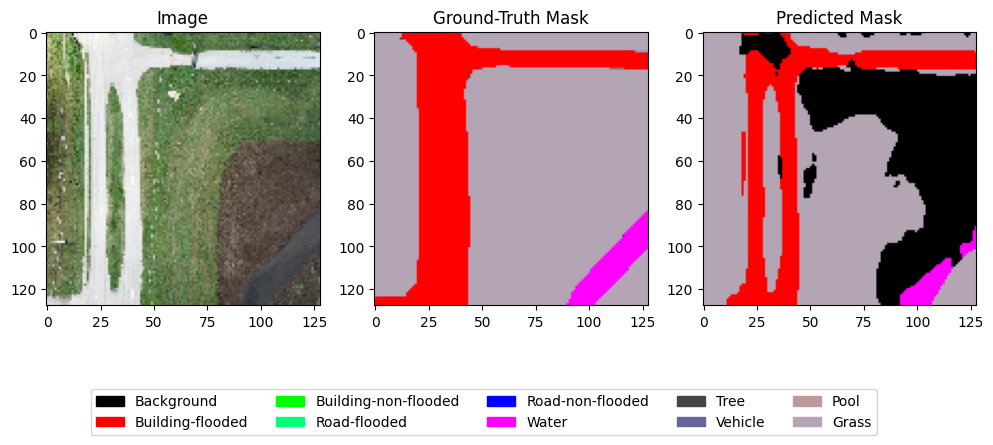

In [29]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


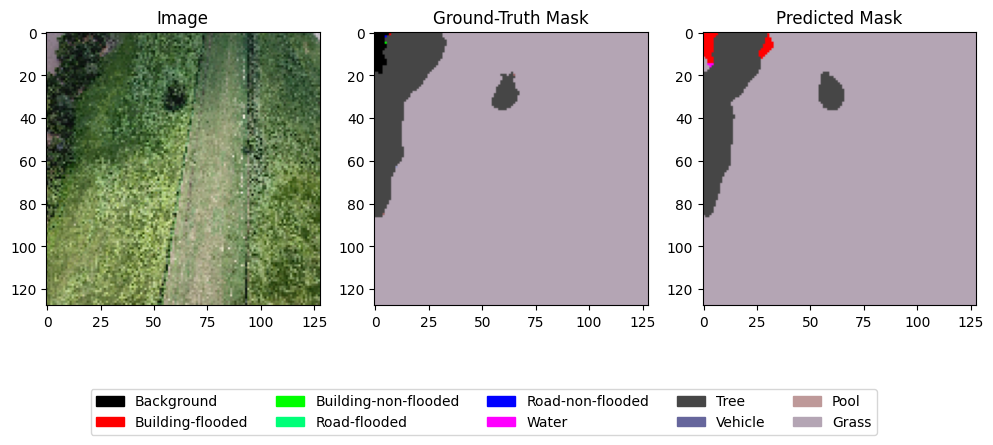

In [30]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


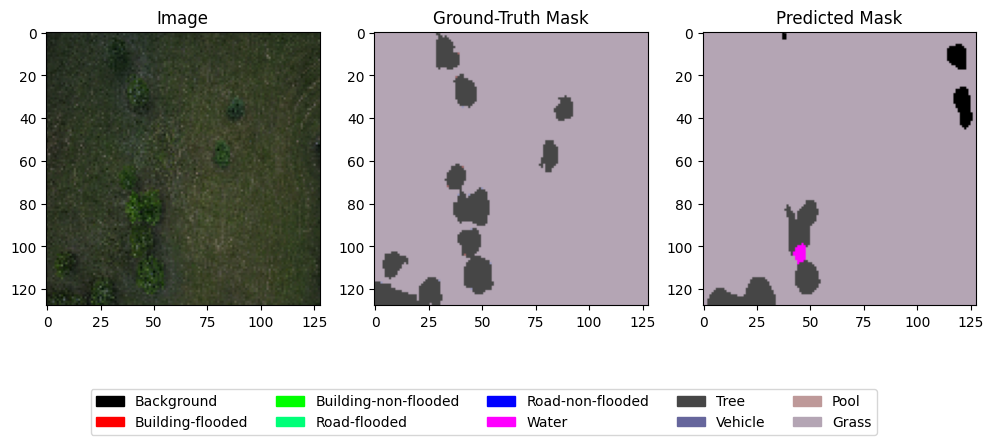

In [31]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


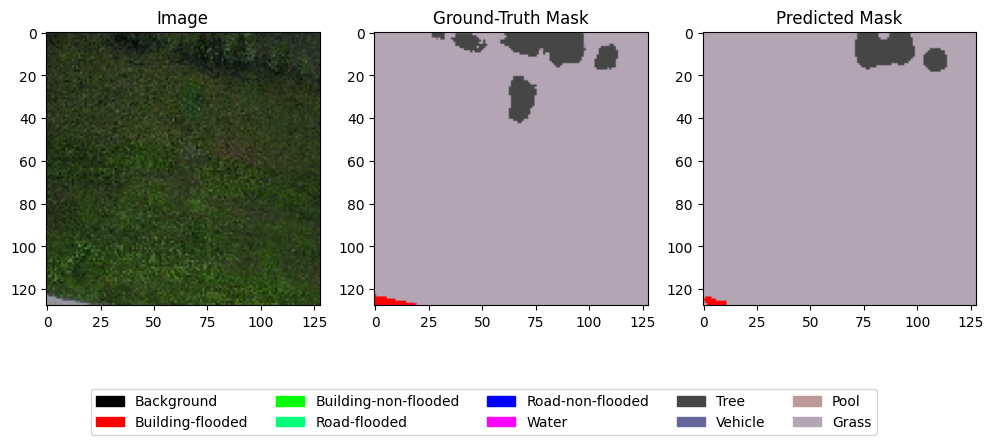

In [32]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


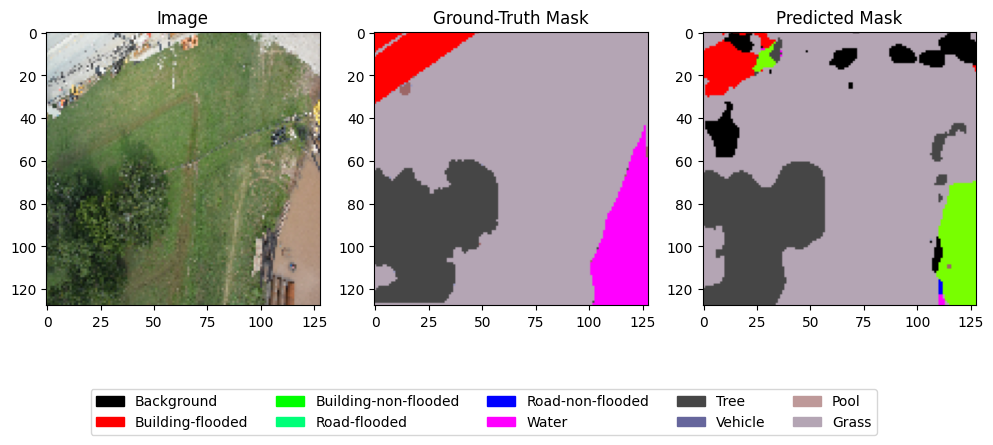

In [33]:
display_random_function()